# Speech processing MFFC's feature extraction

<ul style="list-style-type:none;">
    <li>1. Introduction</li>
    <li>2. Audio file inspection</li>
    <li>3. Vocal activity detection</li>
    <li>4. Pre-emphasis</li>
    <li>5. Framing</li>
    <li>6. Window</li>
    <li>7. Fourier transform</li>
    <li>8. Mel scale filter bank</li>
    <li>9. Discrete cosine transform</li>
    <li>10. Liftering and Mean normalization</li>
    <li>11. Deltas and Delta-Deltas</li>
    <li>12. Conclusion</li>
</ul>


## 1. Introduction

Extract information from speech signals is one of the most important steps in speech recognition and speaker recognition systems and even in other aplications involving extracting information from digital audio signals. 

Speech signal conveys a lot of information, information such as language, greographic, emotional and biometric information of the speaker, and of course the message of speech is some of the information we can extract from a digital speech signal, other information present in a digital speech signal could be acoustic response of the location where the signal was recorded, acoustic caracteristics of the channel transmition, etc.  

Digital representation of speech can produce a lot of data and some times many of that data is not useful for a speech processing application, a signal recorded at a sample rate of 44.1kHz, produce 44100 registers per second, and most of the cases for speech applications 16kHz or 12kHz could be enough. Also, speech signal is not stationary and the same message transmited even for the same person can be different in the time and the frequency domain, these characteristics made the speech signal a very complex type of signal, because of the way is produced, perceived, registered and because of the information encoded in it, requires special considerations in the processing steps.

The analysis of speech signals can be made in the time or in the frequency domain, in order to extract the information we need, we use techniques that models the way speech is produced or the way the speech is perceived, there are some techniques with different aproaches, but one of the most popular speech processing techniques is the Mel Frequency Cepstral Coefficients MFCC's.  

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
import librosa
import soundfile as sf
import IPython.display as ipd
from scipy.fftpack import dct

#sns.set()
audio_file = "/Users/humanrobot/Documents/dev/data_sets/JFK.wav"

In [2]:
def print_properties(s, sr):
    print("Shape        ",s.shape)
    print("Type         ",s.dtype)
    print("Sample rate  ",sr)
    print("Seconds      ",s.shape[0]/sr)
    return None

def plot_signal(sig,sr):
    t = [i/sr for i in range(len(sig))]
    s_w = 256
    fig = plt.figure(figsize=(16,9))
    plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=None)
    ax1 = fig.add_subplot(211)
    ax1 = sns.lineplot(x=t,y=sig)
    ax1.set_title('Time domain')
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Seconds')
    ax1.set_xlim([t[0],t[-1]])
    ax2 = fig.add_subplot(212)
    if(len(sig) < s_w):
        z = np.zeros(int(s_w - len(sig)))
        sig = np.append(sig, z)
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sig, Fs=sr, NFFT=s_w)
    ax2.set_title('Frequency domain')
    ax2.set_ylabel('Frequency')
    ax2.set_xlabel('Seconds')
    return None

def plot_power_spectrum(sig,sample_rate):
    f = [(i*sample_rate)/(2*len(sig)) for i in range(len(sig))]
    fig = plt.figure(figsize=(16,5))
    #plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=None)
    #ax1 = fig.add_subplot(211)
    ax1 = sns.lineplot(x=f,y=sig)
    ax1.set_title('Pow spectrum')
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Frequency')
    ax1.set_xlim([f[0],f[-1]])

def vad(mono_signal, buff_size, threshold):
    total_s = int(mono_signal.shape[0]/buff_size)
    signal = []
    for i in range(total_s):
        sig = mono_signal[i*buff_size:(i+1)*buff_size]
        rms = math.sqrt(np.square(sig).mean())
        if(rms > threshold):
            signal = np.append(signal,sig)
    return signal

def pre_emphasis(signal, pre_emphasis_coef):
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis_coef * signal[:-1])
    return emphasized_signal

def framing(signal, sample_rate, frame_size, frame_stride):
    nsamples_signal = len(signal)
    nsamples_frame = int(sample_rate*frame_size)
    nsamples_stride = int(sample_rate*frame_stride)
    n_frames = int(np.ceil((nsamples_signal-nsamples_frame)/nsamples_stride) + 1)
    nsamples_padding = ((n_frames - 1)*nsamples_stride + nsamples_frame) - nsamples_signal
    z = np.zeros(nsamples_padding)
    signal = np.append(signal, z)
    frames = np.empty((n_frames,nsamples_frame))
    for i in range(n_frames):
        left = i*nsamples_stride
        right = left + nsamples_frame
        frame = signal[left:right]
        frames[i] = frame
    return frames

def window(frames, frame_length, window_type = 'hamming'):
    if(window_type == 'hanning'):
        out = frames*np.hanning(frame_length)
    elif(window_type == 'blackman'):
        out = frames*np.blackman(frame_length)
    else:
        out = frames*np.hamming(frame_length)
    return out

def frame_matrix(signal,sample_rate, pre_emphasis_coef, frame_in_secs, overlap_in_secs, window_type):
    emph_signal = pre_emphasis(signal, pre_emphasis_coef)
    frames = framing(emph_signal, sample_rate, frame_in_secs, overlap_in_secs)
    window_frames = window(frames, int(frame_in_secs*sample_rate), window_type)
    return window_frames

In [ ]:
#LPC
def correlations_ref(frames,p):
    c    = np.correlate(frames,frames, 'full')
    mid  = len(c)//2
    R = c[mid:mid+p+1]
    return R

def correlations(frames, p):
    phi = np.zeros(p+1)
    for i in range(1,p+2):
        sigma = 0
        for m in range(N-i+1):
            sigma += frames[m]*frames[m+i-1]
        phi[i-1] = sigma
    return phi

def Levinson_Durbin(R, p):
    E = np.zeros(p+1)
    k = np.zeros(p)
    alpha = np.zeros((p,p))
    i = 1
    E[i-1] = R[i-1]
    k[i-1] = R[i]/E[i-1]
    alpha[i-1][i-1] = k[i-1]
    E[i] = (1 - k[i-1]**2)*E[i-1]

    for i in range(2,p+1):
        suma = 0
        for l in range(1,i):
            suma += alpha[i-2][l-1]*R[i-l]
        k[i-1] = (R[i] - suma)/E[i-1]
        alpha[i-1][i-1] = k[i-1]
        for j in range(1,i):
            alpha[i-1][j-1] = alpha[i-2][j-1] - k[i-1]*alpha[i-2][i-j-1]
        E[i] = (1 - k[i-1]**2)*E[i-1]
    return alpha[p-1]

## 2. Audio file inspection

In this example, we are goin to use an extract of JFK speech. This example is at 44.1kHz so we are going to resample it at 8kHz in order to reduce the data load. 

We can do this because of the Nyquist-Shannon sampling theorem, which states basically that the highest frequency registered at a digital signal is half of the sample rate, so at 8kHz the highest frequency captured is 4kHz, maybe that is not enough for high quality audio systems design for music, but for speech signals that is enough, many telecommunication systems samples signals at 12kHz so 8kHz is fine for this example.

In [3]:
ipd.Audio(audio_file)

In [4]:
sr, s = wavfile.read(audio_file)
print_properties(s, sr)

Shape         (463050, 2)
Type          int16
Sample rate   44100
Seconds       10.5


In [5]:
samples, sample_rate = librosa.load(audio_file, mono=True, sr=8000)
print_properties(samples, sample_rate)

Shape         (84000,)
Type          float32
Sample rate   8000
Seconds       10.5


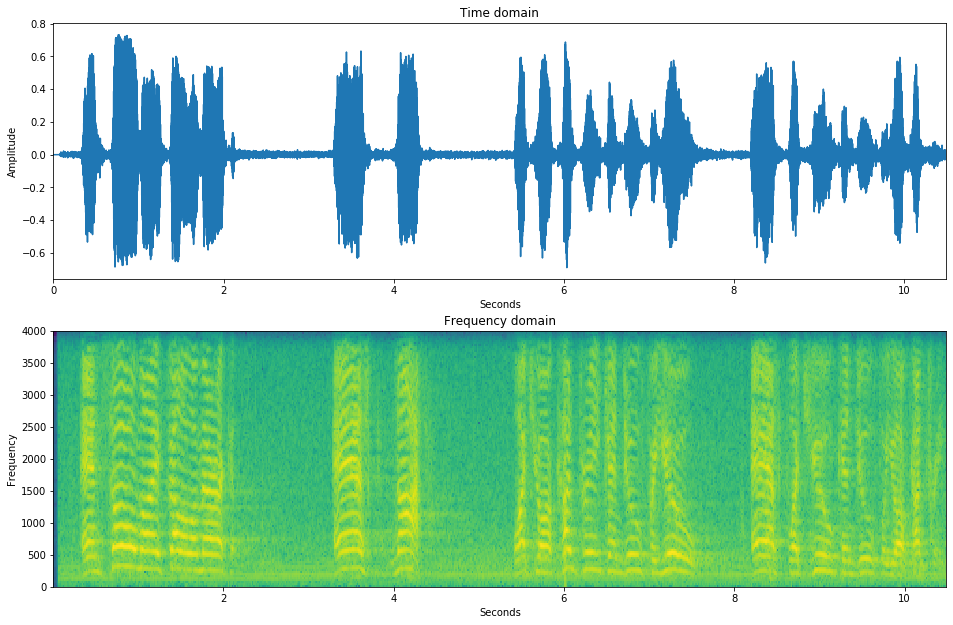

In [6]:
plot_signal(samples,sample_rate)

## 3. Vocal activity detection

As we can see from the plot, or just hear from the audio, there are somo fragments of silence, we can delete those fragments and reduce the data load a little more. 

Vocal activity detection (VAD) is a processing technique which detects absence of human speech in the signal, this can be made measuring the root mean square (RMS) of the signal, if the value is below of some threshold, we consider there is no human speech presence, so we can delete that fragment.

Here I made a very simple implementation of a VAD function.

In [7]:
vad_signal = vad(samples,1000,0.012)
print_properties(vad_signal, sample_rate)

Shape         (61000,)
Type          float64
Sample rate   8000
Seconds       7.625


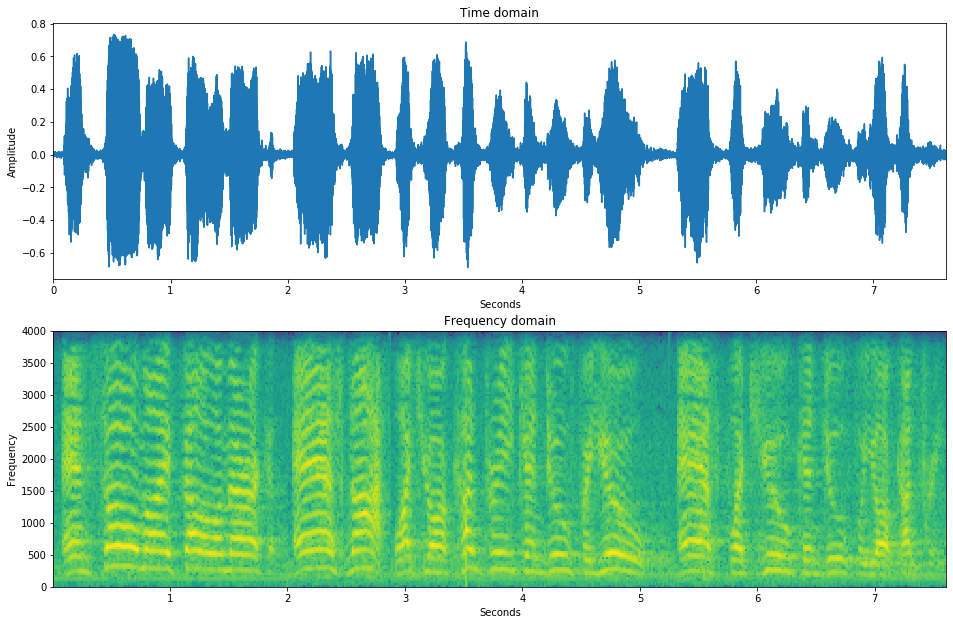

In [8]:
plot_signal(vad_signal,sample_rate)

In [9]:
sf.write('vad_signal.wav', vad_signal, sample_rate, subtype='PCM_16')
ipd.Audio('vad_signal.wav')

## 4. Pre-emphasis

Pre-emphasis is a very simple and common technique used in speech processing. Lower frequencies carries more energy than high frequencies, and high frequencies tends to decay much more faster than lower frequencies, one way to compensate for this characteristic is by applying a pre-emphasis filter, this filter flattens the spectrum of the signal making it more homogeneus.

In [10]:
emph_signal = pre_emphasis(vad_signal, 0.95)
print_properties(emph_signal, sample_rate)

Shape         (61000,)
Type          float64
Sample rate   8000
Seconds       7.625


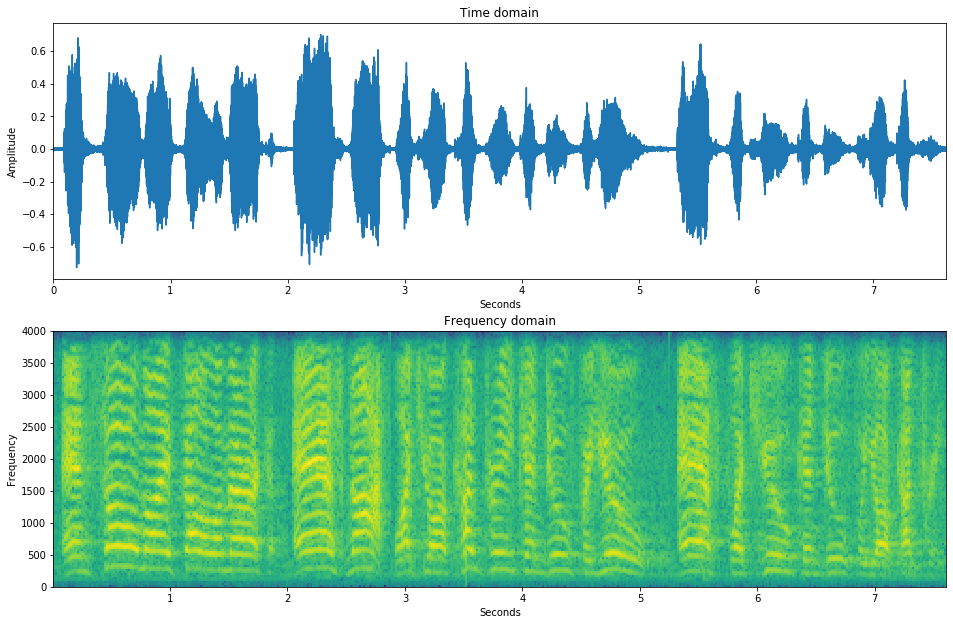

In [11]:
plot_signal(emph_signal,sample_rate)

In [12]:
sf.write('emph_signal.wav', emph_signal, sample_rate, subtype='PCM_16')
ipd.Audio('emph_signal.wav')

## 5. Framing

As we mention before speech signals are not stationary, and fluctuate a lot over time, so it's not useful at all apply Fourier transform across the entire signal, so we split the signal in overlapping small fragments. This process led us with small chunks of signal tha we can assume are stationary and by applying the Fourier transform we can get obtain a good aproximation of the frequency contour of the signal. 

In [13]:
frame_in_secs = 0.025
overlap_in_secs = 0.010
frames = framing(emph_signal,sample_rate,frame_in_secs,overlap_in_secs)
frames.shape

(761, 200)

/Users/humanrobot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=256).


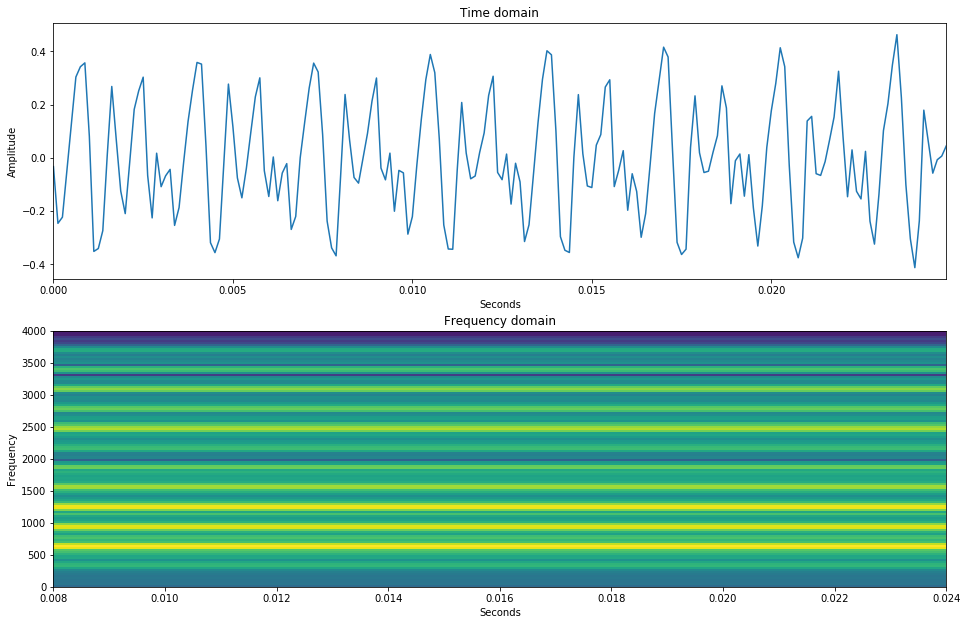

In [14]:
plot_signal(frames[49],sample_rate)

## 6. Window

Because of the nature of the fast Fourier transform we need to apply a window to eliminate artifacts. There are some windows function, like Hamming, Hanning, Blackman and others, but these mentioned are the most commun, and most of the literature mentione the Hamming window.

/Users/humanrobot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=256).


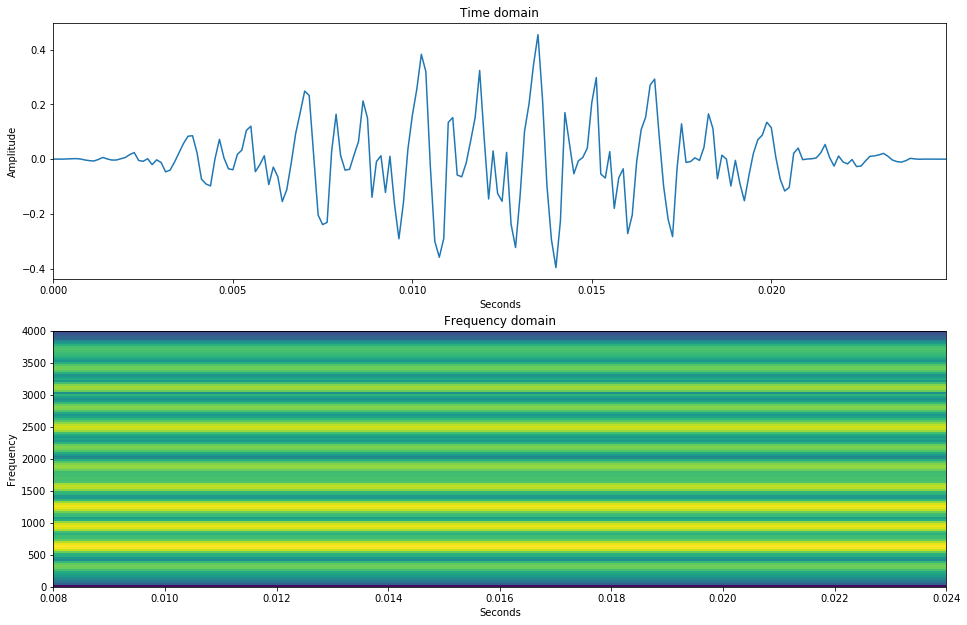

In [15]:
window_frames = window(frames, int(frame_in_secs*sample_rate),'hanning')
plot_signal(window_frames[50],sample_rate)

# Prepare signal

In [16]:
pre_emphasis_coef = 0.97
frame_in_secs = 0.035
overlap_in_secs = 0.015
window_type = 'hamming'
frames_matrix = frame_matrix(vad_signal, sample_rate, pre_emphasis_coef, frame_in_secs, overlap_in_secs, window_type)

In [17]:
frames_matrix.shape

(507, 280)

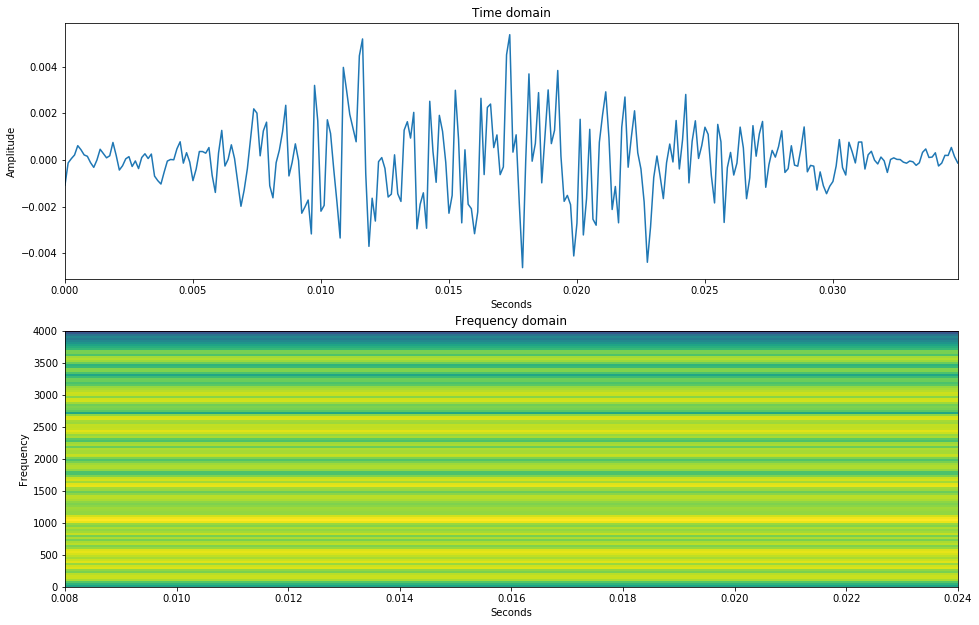

In [18]:
plot_signal(frames_matrix[0],sample_rate)

# MFCC's

## 7. Fourier transform and power spectrum

The signal is most useful in the frequency domain, so we apply the fast Fourier transform (FFT) and calculate the power spectrum of the signal.

In [19]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(window_frames, NFFT))
pow_frames = (mag_frames ** 2)/NFFT
pow_frames.shape

(761, 257)

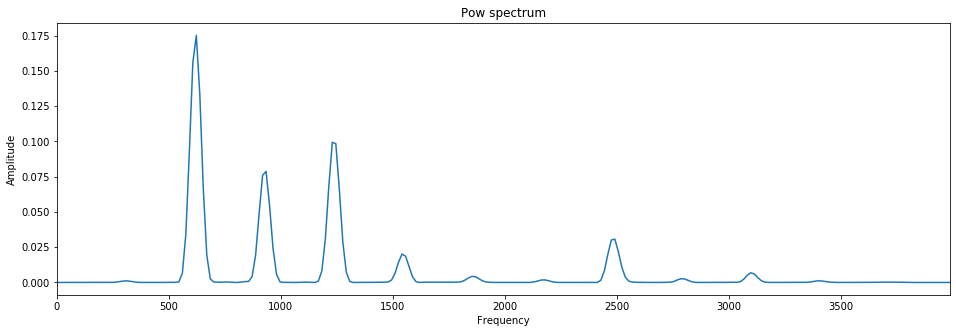

In [20]:
plot_power_spectrum(pow_frames[50],sample_rate)

## 8. Mel scale filter bank

The Mel scale is an empirical perceptual scale of pitches which tries to model the way humans perceive sound, we tend to hear some frequencies with more emphasis than others an the frequencies response is not linear or at least is not linear across te spectrum, MFCC features applies this filter aming to mimic the non linear response to frequencies present in human hearing perception. 

The filter bank consist in applyin a group of triangular filters on a Mel-scale to the power spectrum to extract frequency bands. The number of filters varies between 20 to 40, and in some cases those filters doesn't cover the full spectrum.

In [21]:
def freq_to_mel(freq):
    mel = 1127*math.log(1 + freq/700)
    return mel
def mel_to_freq(mel):
    freq = 700*(math.exp(mel/1127) - 1)
    return freq
def freq_to_bin(freq, nfft, sample_rate):
    bin_freq = int(np.floor(((nfft + 1)*freq/sample_rate)))
    return bin_freq
def triangular_filter(bins, n_bin, length):
    filt = np.zeros(length)
    l = int(bin_freqs[n_bin - 1])
    c = int(bin_freqs[n_bin])
    r = int(bin_freqs[n_bin + 1])
    for i in range(l, c):
        filt[i] = (i - l) / (c - l) 
    for i in range(c, r):
        filt[i] = (i - r) / (c - r)
    return filt
def filter_banks(bin_freqs, nfft):
    n_filt = len(bin_freqs) - 2
    length = int(np.floor(nfft / 2 + 1))
    fbank = np.zeros((n_filt,length))
    for i in range(1, n_filt + 1): 
        fbank[i - 1] = triangular_filter(bin_freqs, i, length)
    return fbank

In [22]:
n_filt = 20
mels = np.linspace(freq_to_mel(0), freq_to_mel(sample_rate/2), n_filt + 2)
freqs = [mel_to_freq(mel) for mel in mels]
bin_freqs = [freq_to_bin(f, NFFT, sample_rate) for f in freqs]

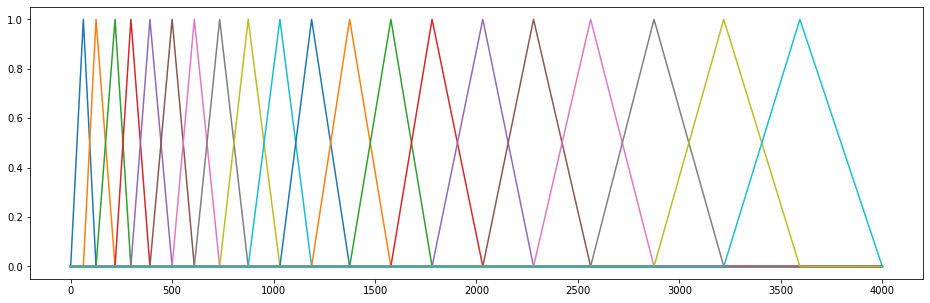

In [23]:
fbank = filter_banks(bin_freqs,  NFFT)
freq_label = np.linspace(0, sample_rate/2, len(fbank[0]))
fig = plt.figure(figsize=(16,5))
for i in range(n_filt):
    plt.plot(freq_label, fbank[i])
plt.show()

In [24]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks) 
filter_banks = 20 * np.log10(filter_banks)

## 9. Discrete cosine transform

The Discrete Cosine Transform (DCT) is applying to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks.As we mention before some of the coefficients are discarted and the resulting cepstral coefficients 2-13 are retained. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients.

In [25]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

## 10. Liftering and Mean normalization

In order to improve the signal to noise ratio, is commun to run to more process, a lift to de-emphasize higher MFCCs and a mean normalization to balance the spectrum.

In [26]:
cep_lifter = 22
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

In [27]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [28]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

## 11. Deltas and Delta-Deltas

Speech signals are time-variant signals and in a constant flux, and is important to capture this behavior, a common method for extracting information about such transitions is to determine the first difference of signal features, known as the delta of a feature, and the second difference, known as the delta-delta.

In [29]:
delta = np.array([mfcc[i]-mfcc[i-1] for i in range(1,mfcc.shape[0])])
delta_delta = np.array([delta[i]-delta[i-1] for i in range(1,delta.shape[0])])

# LPC's

### The autocorrelation method

In [30]:
N = frames_matrix.shape[1]

In [31]:
p = 4
phi_matrix = np.zeros((p,p))
psi_matrix = np.zeros((p,1))

In [32]:
for i in range(1,p+1):
    sigma = 0
    for m in range(N - i):
        sigma += frames_matrix[0][m]*frames_matrix[0][m+i]
    psi_matrix[i-1] = sigma
    
for i in range(1,p+1):
    for k in range(1,p+1):
        sigma = 0
        for m in range(N-i+1):
            sigma += frames_matrix[0][m]*frames_matrix[0][m+i-k]
        phi_matrix[i-1][k-1] = sigma
for i in range(p):
    print(phi_matrix[i])

[ 6.65938109e-04  2.04281713e-04 -5.88037110e-05  3.87888886e-05]
[ 2.04140574e-04  6.65921168e-04  2.04300038e-04 -5.87340626e-05]
[-5.86674320e-05  2.04158899e-04  6.65901346e-04  2.04224698e-04]
[ 3.93942675e-05 -5.85977836e-05  2.04083559e-04  6.65614999e-04]


In [33]:
psi_matrix

array([[ 2.04140574e-04],
       [-5.86674320e-05],
       [ 3.93942675e-05],
       [-7.96907531e-05]])

In [34]:
c    = np.correlate(frames_matrix[0],frames_matrix[0], 'full')
mid  = len(c)//2
R = c[mid:mid+p+1]
R

array([ 6.65938109e-04,  2.04140574e-04, -5.86674320e-05,  3.93942675e-05,
       -7.96907531e-05])

In [35]:
k = np.zeros(p+1)
E = np.zeros(p+1)
alpha = np.zeros((p+1,p+1))

i = 1
E[0] = R[0]
k[i] = R[i]/E[i-1]
alpha[i][i] = k[i]
E[i] = (1 - k[i]**2)*E[i-1]

for i in range(2,p+1):
    suma = 0
    for l in range(1,i):
        suma += alpha[i-1][l]*R[i-l]
    k[i] = (R[i] - suma)/E[i-1]
    alpha[i][i] = k[i]
    for j in range(1,i):
        alpha[i][j] = alpha[i-1][j] - k[i]*alpha[i-1][i-j]
    E[i] = (1 - k[i]**2)*E[i-1]
alpha

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.30654587,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.36814664, -0.20095126,  0.        ,  0.        ],
       [ 0.        ,  0.40355281, -0.26581605,  0.17619282,  0.        ],
       [ 0.        ,  0.44976677, -0.33553747,  0.28204149, -0.26229197]])

In [67]:
k = np.zeros(p+1)
E = np.zeros(p+1)
alpha = np.zeros((p,p))

i = 1
E[0] = R[0]
k[i-1] = R[i]/E[i-1]
alpha[i-1][i-1] = k[i-1]
E[i] = (1 - k[i-1]**2)*E[i-1]

for i in range(2,p+1):
    suma = 0
    for l in range(1,i):
        suma += alpha[i-2][l-1]*R[i-l]
    k[i-1] = (R[i] - suma)/E[i-1]
    alpha[i-1][i-1] = k[i-1]
    for j in range(1,i):
        alpha[i-1][j-1] = alpha[i-2][j-1] - k[i-1]*alpha[i-2][i-j-1]
    E[i] = (1 - k[i-1]**2)*E[i-1]
k

array([ 0.        ,  0.30654587, -0.20095126,  0.17619282, -0.26229197])

In [105]:
R = correlations(frames_matrix[0],p)
a = Levinson_Durbin(R, p)

In [106]:
R

array([ 6.65938109e-04,  2.04140574e-04, -5.86674320e-05,  3.93942675e-05,
       -7.96907531e-05])

In [107]:
toeplitz.dot(a.transpose())

array([ 2.04140574e-04, -5.86674320e-05,  3.93942675e-05, -7.96907531e-05])

## 12. Conclusion

The MFCC is a highly used speech processing technique in speech recognition and speaker recognition systems, that emulates the human perception of speech and extracts information from signal, the process is composed from several steps and each step need to define some parameters, these parameters are object to optimization, so we let that to further work.